In [24]:
from torch.utils import data
from torchvision import transforms
from PIL import Image
import torch
import os
import random
import matplotlib.pyplot as plt
import glob

In [2]:
root_dir = '/media/talmacsi/48a93eb4-f27d-48ec-9f74-64e475c3b6ff/Downloads/data/rgb_anon'
mode = 'train'
selected_conditions = ['rain', 'fog'] # snow
img_paths = []

for condition in selected_conditions:
    foler_dir = os.path.join(root_dir, condition, mode)
    print(foler_dir)
    for folder in os.listdir(foler_dir):
        folder_path = os.path.join(foler_dir, folder)
        for img_file in os.listdir(folder_path):
            if img_file.endswith('.jpg') or img_file.endswith('.png'):
                img_paths.append(os.path.join(folder_path, img_file))

/media/talmacsi/48a93eb4-f27d-48ec-9f74-64e475c3b6ff/Downloads/data/rgb_anon/rain/train
/media/talmacsi/48a93eb4-f27d-48ec-9f74-64e475c3b6ff/Downloads/data/rgb_anon/fog/train


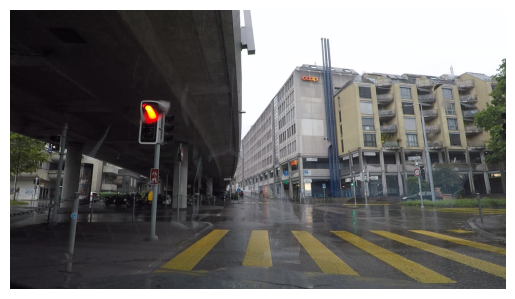

In [3]:
rnd_image = Image.open(random.choice(img_paths))
plt.imshow(rnd_image)
plt.axis("off")
plt.show()

In [4]:
rnd_image.width, rnd_image.height

(1920, 1080)

In [25]:
class ACDCDataset(data.Dataset):
    def __init__(self, root_dir, selected_conditions = ['rain', 'fog', 'night'], transform=None):
        self.root_dir = root_dir
        self.selected_conditions = selected_conditions
        self.transform = transform

        self.img_paths = []

        self.preprocess()

    def preprocess(self):
        for condition in self.selected_conditions:
            for split in ['train', 'val', 'test']:
                folder_dir = os.path.join(self.root_dir, condition, split)
                # Use glob to find all .jpg and .png files recursively
                pattern = os.path.join(folder_dir, '**', '*.[jp][pn]g')
                img_files = glob.glob(pattern, recursive=True)
                self.img_paths.extend(img_files)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image_tensor = self.transform(image)
        else:
            image_tensor = transforms.ToTensor()(image)
            image_tensor = (image_tensor * 2) - 1
        return image_tensor
    

def get_loader(image_dir, selected_attrs, image_size=128, batch_size=16, num_workers=4):
    """Build and return a data loader."""
    
    # Create Datalaoders
    train_transform = transforms.Compose([
            transforms.Resize(image_size, transforms.InterpolationMode.BILINEAR),  # Resize the smallest side to 128 and maintain aspect ratio
            transforms.RandomCrop(image_size), 
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambd=lambda x: x * 2.0 - 1.0),  # Normalize to [-1, 1]
             
        ])

    dataset = ACDCDataset(root_dir=image_dir, selected_conditions=selected_attrs, transform=train_transform)
    print(dataset.__len__())

    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers)
    return data_loader

2000


torch.Size([3, 128, 128])
tensor(-0.9608) tensor(1.)


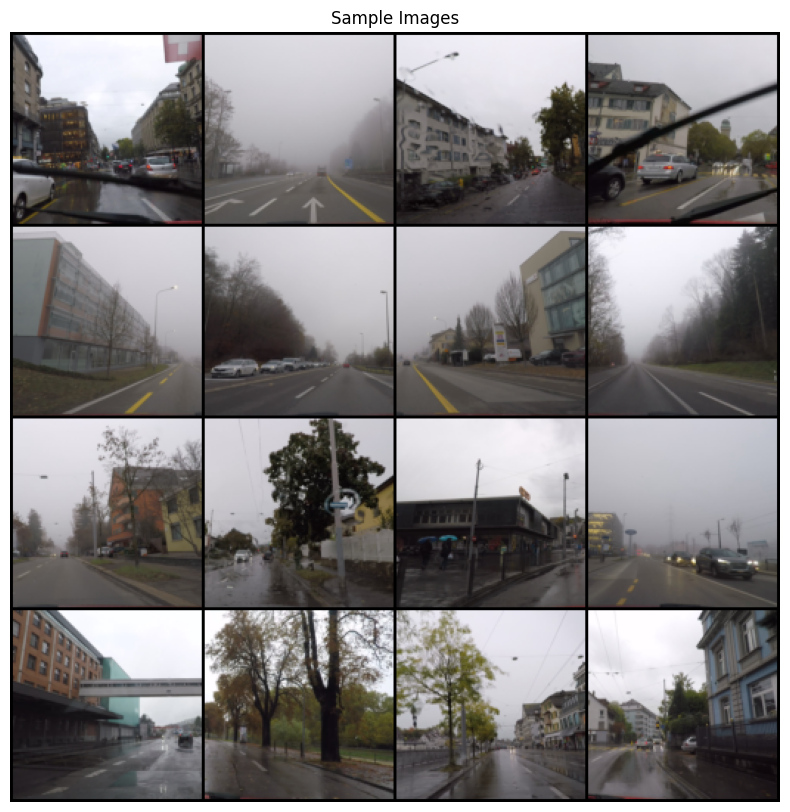

In [28]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils


# Get the data loader
data_loader = get_loader(image_dir=root_dir, 
                         selected_attrs=['rain', 'fog'], 
                         batch_size=16, 
                         num_workers=4)



# Get a batch of images
images = next(iter(data_loader))

print(images[0].shape)
print(images[0].min(), images[0].max())

# Normalize the images
denorm_images = (images + 1) / 2

# Visualize the images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Sample Images")
plt.imshow(vutils.make_grid(denorm_images, nrow=4, padding=2, normalize=False).permute(1, 2, 0))
plt.show()


# CityScapes

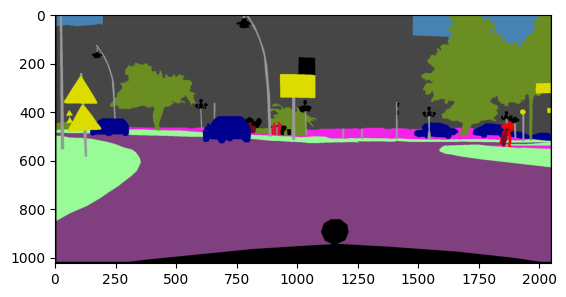

In [48]:
from PIL import Image
import numpy as np
test_label_path = 'data/cityscapes/gtFine/train/aachen/aachen_000000_000019_gtFine_color.png'
test_label = Image.open(test_label_path)
test_label_array = np.array(test_label)
plt.imshow(test_label)

In [51]:
test_label_array[0]

array([[  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       ...,
       [  0,   0,   0, 255],
       [  0,   0,   0, 255],
       [  0,   0,   0, 255]], dtype=uint8)

In [64]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_tensor, to_pil_image

image_size = 128

def load_cityscapes_dataset(data_dir, batch_size=4, train=True):
    """
    Load the Cityscapes dataset.
    
    Parameters:
        data_dir (str): The root directory of the Cityscapes dataset.
        batch_size (int): Number of samples per batch.
        train (bool): If True, load the training set. Otherwise, load the validation set.
        
    Returns:
        DataLoader: DataLoader object for the Cityscapes dataset.
    """

    # Define the transformation
    image_transform = transforms.Compose([
        transforms.Resize(image_size, transforms.InterpolationMode.BILINEAR),  # Resize the smallest side to 128 and maintain aspect ratio
        transforms.RandomCrop(image_size), 
        transforms.ToTensor(), # Convert images to PyTorch tensors
    ])


    # Custom transform function for images only
    def transform_image_only(sample):
        image, label = sample
        label = np.array(to_pil_image(label), dtype=np.int32)  # Convert 
        return image_transform(image), label


    # Load the Cityscapes dataset
    dataset = datasets.Cityscapes(root=data_dir, 
                                  split='train' if train else 'val', 
                                  mode='fine', # 'fine' for fine annotations, 'coarse' for coarse annotations
                                  target_type='semantic', # Load semantic segmentation labels
                                  transform=transform_image_only, 
                                  )

    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader

# Example usage
data_dir = 'data/cityscapes' # You should replace this with the actual path
train_loader = load_cityscapes_dataset(data_dir, batch_size=4, train=True)

# Now you can iterate over train_loader to get your batches


In [66]:
# Iterate over train_loader to get your batches
for images, labels in train_loader:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break  # Remove this break to process the entire dataset

TypeError: cannot unpack non-iterable Image object

In [65]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Show images and semantic labels in pairs
fig, axes = plt.subplots(len(images), 2, figsize=(10, 10))

for i, (image, label) in enumerate(zip(images, labels)):
    # Plot image
    axes[i, 0].imshow(image.permute(1, 2, 0))
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Image")

    # Plot semantic label
    axes[i, 1].imshow(label.squeeze(), cmap='gray')
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Semantic Label")

plt.tight_layout()
plt.show()



TypeError: cannot unpack non-iterable Image object

In [61]:
labels[0]

tensor([[[0.0431, 0.0431, 0.0431,  ..., 0.0431, 0.0431, 0.0431],
         [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
         [0.0824, 0.0824, 0.0824,  ..., 0.0824, 0.0824, 0.0824],
         ...,
         [0.0275, 0.0275, 0.0275,  ..., 0.0039, 0.0039, 0.0039],
         [0.0275, 0.0275, 0.0275,  ..., 0.0039, 0.0039, 0.0039],
         [0.0196, 0.0196, 0.0196,  ..., 0.0078, 0.0078, 0.0078]]])

In [10]:
import numpy as np
import torch

def filter_class(image, mask, class_id):
    """
    Filter the image to only show pixels of the specified class ID.

    Parameters:
        image (Tensor): The input image tensor (C x H x W).
        mask (Tensor): The semantic label mask tensor (H x W), with class IDs as values.
        class_id (int): The target class ID to filter.

    Returns:
        Tensor: The filtered image tensor (C x H x W).
    """
    # Ensure the mask is a boolean mask for the target class
    class_mask = (mask == class_id)
    
    # If the image and mask are not tensors, convert them
    if not isinstance(image, torch.Tensor):
        image = torch.tensor(image)
    if not isinstance(class_mask, torch.Tensor):
        class_mask = torch.tensor(class_mask)
    
    # Convert class_mask to the same dimension as image for element-wise multiplication
    class_mask = class_mask.unsqueeze(0)  # Add a dimension for channel (C x H x W)
    class_mask = class_mask.repeat(image.shape[0], 1, 1)  # Repeat the mask for each channel
    
    # Filter the image
    filtered_image = image * class_mask.float()  # Convert mask to float for multiplication
    
    return filtered_image

filter_class(images[0], labels[0], 0)

RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

In [ ]:
def get_class_mask(self, image, segmentor, class_id):
    """
    Generate a binary mask for the specified class_id using the segmentation model.
    
    :param image: Input image tensor.
    :param segmentor: Segmentation model.
    :param class_id: Target class ID for which the mask is generated.
    :return: Binary mask for the specified class.
    """
    with torch.no_grad():
        output = segmentor(image)  # Assuming output is [N, C, H, W]
        mask = torch.argmax(output, dim=1) == class_id  # [N, H, W]
        mask = mask.float()  # Convert to float for multiplication
    return mask.unsqueeze(1)  # Add channel dimension back [N, 1, H, W]